In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_off(file):
    """
    Read OFF Files
    :param file: off file to load
    :return: vertices and faces
    """
    if 'OFF' != file.readline().strip():
        raise Exception('Not a valid OFF header')
    n_verts, n_faces, n_dontknow = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = np.array([[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)])
    faces = np.array([[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)])
    return verts, faces


class Grid:
    def __init__(self, start, end, sectionsX, sectionsY):
        self.points = []
        self.sectionsX = sectionsX
        self.sectionsY = sectionsY
        self.start = start
        self.end = end

    def gridPoints(self):
        """
        Create list of grid points
        :param start: start position of grid
        :param end: end position of grid
        :param sectionsX: the sections in X direction
        :param sectionsY: the sections in Y direction
        :return:
        """
        self.points = []
        deltaX = (self.end[0] - self.start[0]) / self.sectionsX
        deltaY = (self.end[0] - self.start[1]) / self.sectionsY
        for i in range(self.sectionsX):
            gridX = self.start[0] + i*deltaX
            for j in range(self.sectionsY):
                gridY = self.start[1] + j*deltaY
                gridPoint = np.array([gridX,gridY, 0])
                self.points.append(gridPoint)

        return self.points

def b(x):
    """
    Polynomial basis (quadratic, bivariate)
    :param x: 2d Point
    :return: polynomial at this point
    """
    return np.array([1, x[0], x[1], x[0] ** 2, x[0] * x[1], x[1] ** 2])


def phi(h, d):
    """
    Wendland weighting function
    :param h: this function is defined on interval [0,h]
    :param d: distance
    :return: weight
    """
    d = np.clip(d, 0, h)
    return (1 - d / h) ** 4 * (4 * d / h + 1)

def dist2d(a, b):
    return np.linalg.norm(a[:2] - b[:2])
    

def collectInRadius2d(point, points, radius):
    """
    Collection of points in radius of point
    :param point: query point
    :param points: all the points
    :param radius: the radius to search in
    :return:
    """
    collection = []
    for p in points:
        if np.linalg.norm((point[:2] - p[:2])) <= radius:
            collection.append(p)
    return np.array(collection)


class WLS:
    def __init__(self, grid :Grid, radius=.1):
        self.coeffs = []
        self.radius = radius
        grid.gridPoints()
        self.grid = grid
        self.coeffs = [0]*len(grid.points)

    def LSE(self, x_hat, points):
        """
        Moment matrix A (and weighted f basis B) computation for x_hat
        :param x_hat: compute the Matrices of the LSE for this point
        :param points: all the points
        :return:
        """
        N = points.shape[0]
        # Initialize weights
        W = np.zeros((N, N))

        # Compute weights
        W2 = phi(self.radius, dist2d(x_hat[:,None], points))
        for i, x_i in enumerate(points):
            d = dist2d(x_hat, x_i)
            W[i][i] = phi(self.radius, d)

        # Project points into polynomial basis
        X = np.array([b(x) for x in points])

        # Compute the matrices needed for the LSE
        A = X.T.dot(W).dot(X)
        B = X.T.dot(W).dot(points[:, 2])

        return A, B

    def fit(self, points):
        for i, x in enumerate(self.grid.points):
            # Collection step of points in radius
            collected = collectInRadius2d(x, points, self.radius)
            # Setup LSE
            A, B = self.LSE(x, collected)
            # Solve for coefficients
            c = np.linalg.solve(A, B)
            # Store
            self.coeffs[i] = c

    def f(self, x, y):
        point = np.array([x, y, 0])
        
        weights = [phi(self.radius*1.5, np.linalg.norm(point-gp)) for gp in self.grid.points]
        weightsSum = sum(weights)
        
        return sum([weights[j] / weightsSum * b(point).T.dot(self.coeffs[j]) for j, gp in enumerate(self.grid.points)])

In [3]:
vert, _ = read_off(open("franke4.off"))

minAxes = np.amin(vert, axis=0)
maxAxes = np.amax(vert, axis=0)
print(minAxes, maxAxes)

[ 7.826369e-06  2.753492e-04 -1.922172e-01] [0.9999999 0.9990921 1.041042 ]


NameError: name 'griddata' is not defined

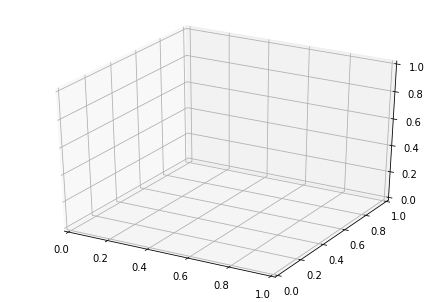

In [30]:
fig = plt.figure()
ax = Axes3D(fig)

xi = np.linspace(minAxes[0], maxAxes[0], 20)
yi = np.linspace(minAxes[1], maxAxes[1], 20)

X, Y = np.meshgrid(xi, yi)
Z = griddata(x, y, z, xi, yi)

ax.scatter(vert[:,0],vert[:,1],vert[:,2], depthshade=False)
ax.view_init(30, 60)
plt.show()

In [20]:
grid = Grid(minAxes, maxAxes, 10, 10)

wls = WLS(grid, 0.1)
wls.fit(vert)

In [ ]:
fig = plt.figure()

X = np.linspace(minAxes[0], maxAxes[0], 20)
Y = np.linspace(minAxes[1], maxAxes[1], 20)
X, Y = np.meshgrid(X, Y)

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title("WLS")
Z = wls.f(X, Y)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.view_init(30, 60)
plt.show()

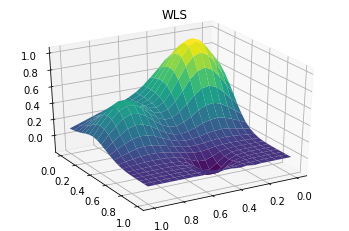